<head><h1 align="center">
Food.com Recipe Interactions
</h1></head>  
  
<head><h3 align="center">Data Exploration & EDA</h3></head>  
    
#### Setup

In [3]:
# %pip install wordcloud

In [4]:
# import libraries
import boto3, re, sys, os, time, math, csv, json, pickle, sagemaker, urllib.request
from os import system
from math import floor
from copy import deepcopy
from sagemaker import get_execution_role
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt  
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from IPython.display import Image                 
from IPython.display import display               
from time import gmtime, strftime                 
from sagemaker.predictor import csv_serializer   

# Setting DataFrame display options
pd.set_option('display.max_rows', 6)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_colwidth', 200)

# Define IAM role
role = get_execution_role()
prefix = 'sagemaker/knn'
containers = {'us-west-2': '174872318107.dkr.ecr.us-west-2.amazonaws.com/knn:1',
              'us-east-1': '382416733822.dkr.ecr.us-east-1.amazonaws.com/knn:1',
              'us-east-2': '404615174143.dkr.ecr.us-east-2.amazonaws.com/knn:1',
              'eu-west-1': '438346466558.dkr.ecr.eu-west-1.amazonaws.com/knn:1',
              'ap-northeast-1': '351501993468.dkr.ecr.ap-northeast-1.amazonaws.com/knn:1',
              'ap-northeast-2': '835164637446.dkr.ecr.ap-northeast-2.amazonaws.com/knn:1',
              'ap-southeast-2': '712309505854.dkr.ecr.ap-southeast-2.amazonaws.com/knn:1'}

my_region = boto3.session.Session().region_name # set the region of the instance
print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the " + containers[my_region] + " container for your SageMaker endpoint.")

Success - the MySageMakerInstance is in the us-east-2 region. You will use the 404615174143.dkr.ecr.us-east-2.amazonaws.com/knn:1 container for your SageMaker endpoint.


# Data

Dataset Filenames in `data/` Reference:  
  
ingr_map.pkl  
  
interactions_test.csv  
interactions_train.csv  
interactions_validation.csv  
  
PP_recipes.csv  
PP_users.csv  
  
RAW_interactions.csv  
RAW_recipes.csv  

test.json  
train.json  

In [7]:
# REFERENCE — Former DataFrame variables
# df = pd.read_csv('data/RAW_recipes.csv')
# int_df = pd.read_csv('data/RAW_interactions.csv')

# pp_df = pd.read_csv('data/PP_recipes.csv')
# usr_df = pd.read_csv('data/PP_users.csv')

# ingID = pd.read_pickle('data/ingr_map.pkl')

# int_train_df = pd.read_csv('data/interactions_train.csv')
# int_val_df = pd.read_csv('data/interactions_validation.csv')

In [8]:
rdf = pd.read_csv('data/RAW_recipes.csv')
idf = pd.read_csv('data/RAW_interactions.csv')

pp_rdf = pd.read_csv('data/PP_recipes.csv')
pp_idf = pd.read_csv('data/PP_users.csv')

ingID = pd.read_pickle('data/ingr_map.pkl')

itrain_df = pd.read_csv('data/interactions_train.csv')
ival_df = pd.read_csv('data/interactions_validation.csv')

# Cleaning & Data Preparation

In [9]:
# Cleaning: Dropping row that contains a NaN value for recipe name
rdf.drop(labels=721, inplace = True)

# Cleaning/FE: Creating columns for recipe's respective nutrients
rdf['kcal'] = rdf.nutrition.apply(lambda x: x[1:-1].split(sep=', ')[0])
rdf['fat'] = rdf.nutrition.apply(lambda x: x[1:-1].split(sep=', ')[1])
rdf['sugar'] = rdf.nutrition.apply(lambda x: x[1:-1].split(sep=', ')[2])
rdf['salt'] = rdf.nutrition.apply(lambda x: x[1:-1].split(sep=', ')[3])
rdf['protein'] = rdf.nutrition.apply(lambda x: x[1:-1].split(sep=', ')[4])
rdf['sat_fat'] = rdf.nutrition.apply(lambda x: x[1:-1].split(sep=', ')[5])
rdf['carbs'] = rdf.nutrition.apply(lambda x: x[1:-1].split(sep=', ')[6])

# Cleaning: Imputing outlier value to median
rdf['minutes'] = np.where(rdf.minutes == 2147483647,
                         rdf.minutes.median(),
                         rdf.minutes)

idf['date'] = pd.to_datetime(idf.date)

# Food.com Recipes and Interactions Dataset

## RAW Interactions Data — `idf`

Represent user reviews and ratings for different recipes  
- Interactions Train Set Total Rows: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**698,901**  
  Interactions Val. Set Total Rows: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **7,023**  
  Interactions Test Set Total Rows: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **12,455**  
  ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾   
  Combined Train/ Val/ Test Sets: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**718,379**  
  **Raw Interactions Set Total Rows:** &nbsp;&nbsp;**1,132,367**  
  ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾  
    
The only null values in the dataset are in the `review` column, where users rated a recipe but did not leave a review comment. Even still, there are only **169** rows (representing user interactions) where this is the case — which is only roughly $\frac{1}{15,000}$ of the total data.  
  
Also to note, I'm not even sure if dropping these null values is necessary, as the `review` feature will not be used for the model.

In [10]:
4.411016e+00

4.411016

In [11]:
1.132367e+06

1132367.0

In [12]:
169/len(idf)

0.00014924490028409517

In [13]:
169/len(idf)

0.00014924490028409517

In [14]:
idf.isna().sum()

user_id        0
recipe_id      0
date           0
rating         0
review       169
dtype: int64

In [15]:
idf.rating.value_counts()

5    816364
4    187360
0     60847
3     40855
2     14123
1     12818
Name: rating, dtype: int64

In [16]:
idf.describe()

,user_id,recipe_id,rating
count,1.132367e+06,1.132367e+06,1.132367e+06
mean,1.384291e+08,1.608972e+05,4.411016e+00
std,5.014269e+08,1.303987e+05,1.264752e+00
min,1.533000e+03,3.800000e+01,0.000000e+00
25%,1.354700e+05,5.425700e+04,4.000000e+00
50%,3.309370e+05,1.205470e+05,5.000000e+00
75%,8.045500e+05,2.438520e+05,5.000000e+00
max,2.002373e+09,5.377160e+05,5.000000e+00


In [17]:
idf.columns

Index(['user_id', 'recipe_id', 'date', 'rating', 'review'], dtype='object')

In [18]:
itrain_df.head()

,user_id,recipe_id,date,rating,u,i
0,2046,4684,2000-02-25,5.0,22095,44367
1,2046,517,2000-02-25,5.0,22095,87844
2,1773,7435,2000-03-13,5.0,24732,138181
3,1773,278,2000-03-13,4.0,24732,93054
4,2046,3431,2000-04-07,5.0,22095,101723


### Hypotheses Testing

 $µ$ 

### `user_id`

>User ID of the interacting user leaving a review and rating.
  
- **226,570 unique** user IDs out of **1,132,367 total** recipe rating/review interactions.
- $83.4\%$ of users have had **no more than 2 interactions** on the site.

Text(0.5, 1.0, 'Top 35 Most Interactive Users')

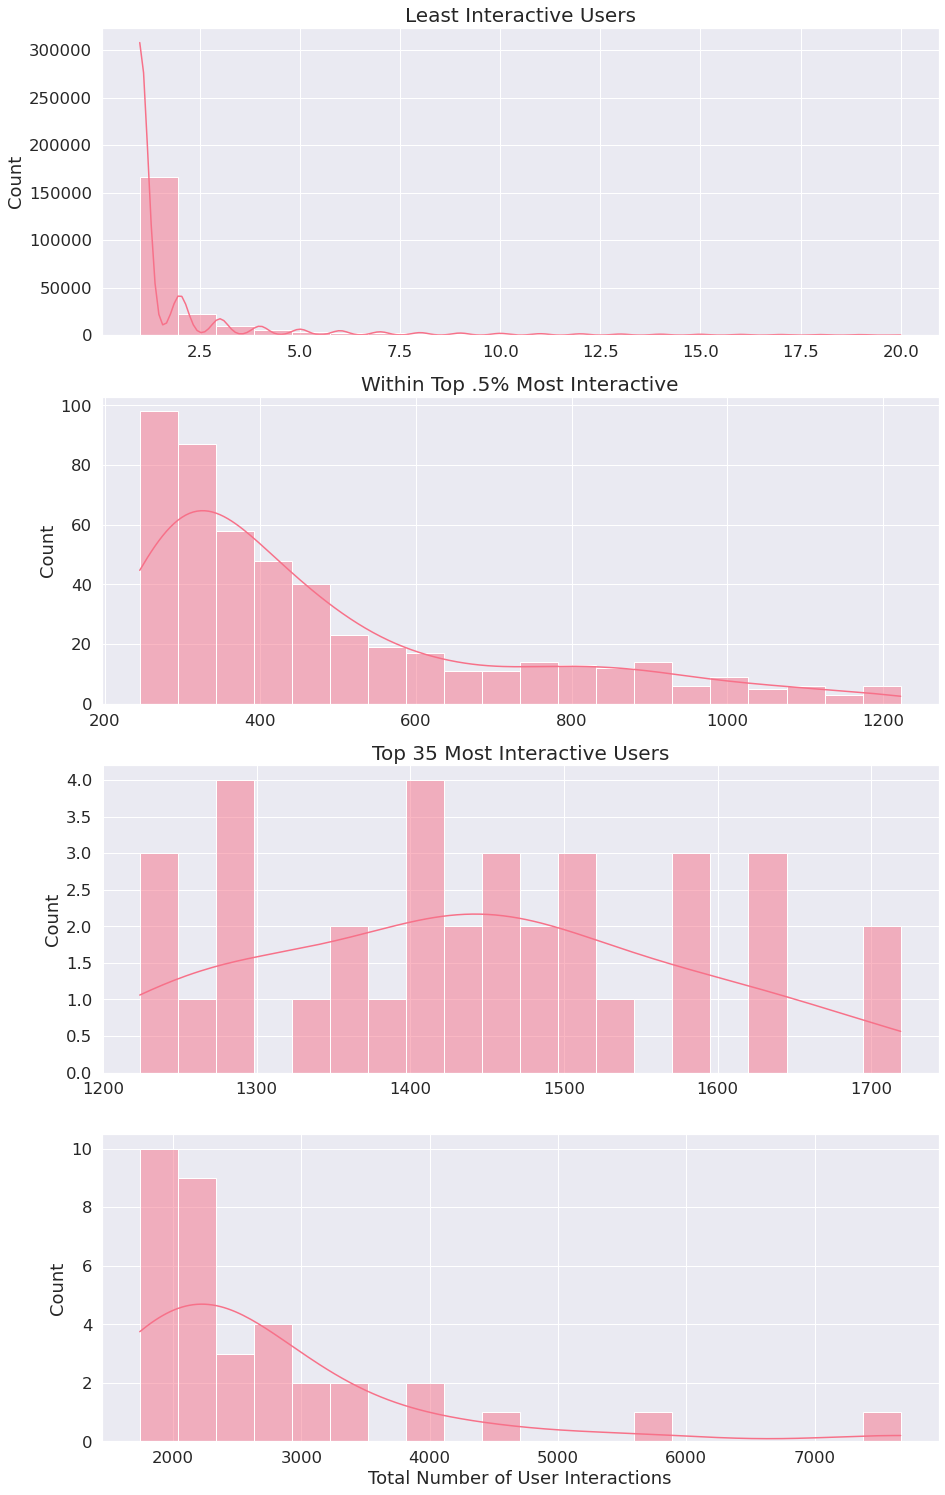

In [167]:
sns.set_theme(font_scale=1.5)
sns.set_palette("husl", 2) 
fig, ax = plt.subplots(4, 1, figsize=(15,26))
sns.histplot(idf.user_id.value_counts().sort_values()[:220000], bins = 20, kde='true', ax=ax[0])
sns.histplot(idf.user_id.value_counts().sort_values()[226000:226500], bins = 20, kde='true', ax=ax[1])
sns.histplot(idf.user_id.value_counts().sort_values()[226500:226535], bins = 20, kde=True, ax=ax[2])
sns.histplot(idf.user_id.value_counts().sort_values()[226535:], bins = 20, kde=True, ax=ax[3])
ax[0].set_xlabel(xlabel=None)
ax[1].set_xlabel(xlabel=None)
ax[2].set_xlabel(xlabel=None)
ax[3].set_xlabel(xlabel='Total Number of User Interactions')

ax[0].set_title(label='Least Interactive Users', size = 20)
ax[1].set_title(label='Within Top .5% Most Interactive', size = 20)
ax[2].set_title(label='Within Top .05% Most Interactive', size = 20)
ax[2].set_title(label='Top 35 Most Interactive Users', size = 20)

# ax[0].set_yticklabels(labels=size = 16)
# ax[1].set_yticklabels(size = 16)
# ax[2].set_yticklabels(size = 16)
# ax[2].set_yticklabels(size = 16);

<AxesSubplot:xlabel='user_id', ylabel='Count'>

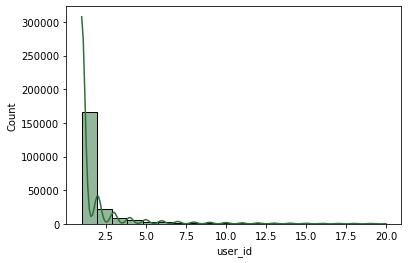

In [106]:
sns.histplot(idf.user_id.value_counts().sort_values()[:220000], bins = 20, kde='true')

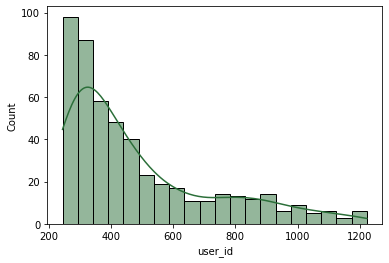

In [105]:
sns.histplot(idf.user_id.value_counts().sort_values()[226000:226500], bins = 20, kde='true');

<AxesSubplot:xlabel='user_id', ylabel='Count'>

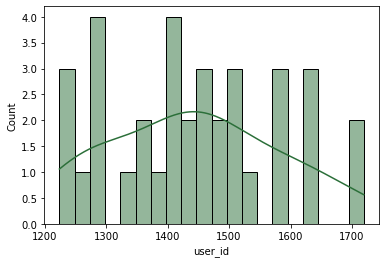

In [107]:
sns.histplot(idf.user_id.value_counts().sort_values()[226500:226535], bins = 20, kde=True)

<AxesSubplot:xlabel='user_id', ylabel='Count'>

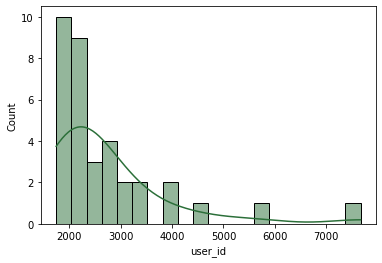

In [108]:
sns.histplot(idf.user_id.value_counts().sort_values()[226535:], bins = 20, kde=True)

In [117]:
(idf.user_id.value_counts().values < 3).sum()

188994

In [115]:
188994/226570

0.8341528004590193

In [89]:
idf.user_id.value_counts()[:5000].tail()

748089     27
990914     27
246695     27
1320681    27
493747     27
Name: user_id, dtype: int64

In [75]:
idf.user_id.value_counts().sort_values(ascending=False)

424680        7671
37449         5603
383346        4628
169430        4076
128473        3917
              ... 
1663031          1
1763398          1
2001280864       1
1824864          1
4317             1
Name: user_id, Length: 226570, dtype: int64

In [65]:
idf.user_id.value_counts()

424680        7671
37449         5603
383346        4628
169430        4076
128473        3917
              ... 
2000504285       1
1934789          1
1988031          1
2067844          1
4098             1
Name: user_id, Length: 226570, dtype: int64

In [20]:
idf.user_id.value_counts()

424680        7671
37449         5603
383346        4628
169430        4076
128473        3917
              ... 
2000504285       1
1934789          1
1988031          1
2067844          1
4098             1
Name: user_id, Length: 226570, dtype: int64

In [21]:
idf.user_id

0               38094
1             1293707
2                8937
3              126440
4               57222
              ...    
1132362        116593
1132363        583662
1132364        157126
1132365         53932
1132366    2001868099
Name: user_id, Length: 1132367, dtype: int64

### `recipe_id`

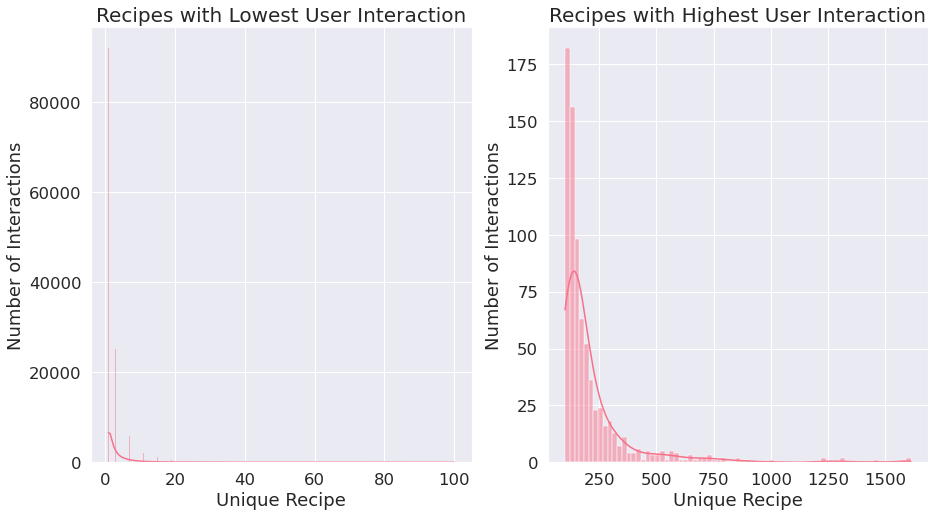

In [198]:
fig, ax = plt.subplots(1,2, figsize=(15, 8), sharey=False)
sns.histplot(x=idf.recipe_id.value_counts().sort_values()[:230851], kde=True, ax=ax[0]);
sns.histplot(x=idf.recipe_id.value_counts().sort_values(ascending=False)[:770], kde=True, ax=ax[1])
ax[0].set_xlabel(xlabel='Unique Recipe')
ax[1].set_xlabel(xlabel='Unique Recipe')

ax[0].set_ylabel(ylabel='Number of Interactions')
ax[1].set_ylabel(ylabel='Number of Interactions')

ax[0].set_title(label='Recipes with Lowest User Interaction', size = 20)
ax[1].set_title(label='Recipes with Highest User Interaction', size = 20);

In [185]:
(idf.recipe_id.value_counts() > 100).sum()

769

In [171]:
(idf.recipe_id.value_counts() > 1000).sum()

8

In [175]:
((idf.recipe_id.value_counts() > 100) & (idf.recipe_id.value_counts() < 500)).sum()

721

In [176]:
((idf.recipe_id.value_counts() > 500) & (idf.recipe_id.value_counts() < 1000)).sum()

40

In [174]:
((idf.recipe_id.value_counts() > 100) & (idf.recipe_id.value_counts() < 1000)).sum()

761

In [177]:
(idf.recipe_id.value_counts() < 100).sum()

230850

### `date`

There are **6,396 total dates** in the sample in which interactions are recorded. The data spans interactions that take place over the course of approximately **19 years**.  
- The earliest date on record in the sample is **January 25, 2000**.
- The final date on record in the sample is **December 20, 2018**.

The wild variance in the lineplot below is caused by a large increase in user rating/review interactions after 2002.  
- between **2000-2002**, there are only **3012 total interactions**
- between **2002-2003**, there are **20922 total interactions**. 
- the interactions from the sample continue to increase until a peak around 2008.

In [42]:
idf.date.max()

Timestamp('2018-12-20 00:00:00')

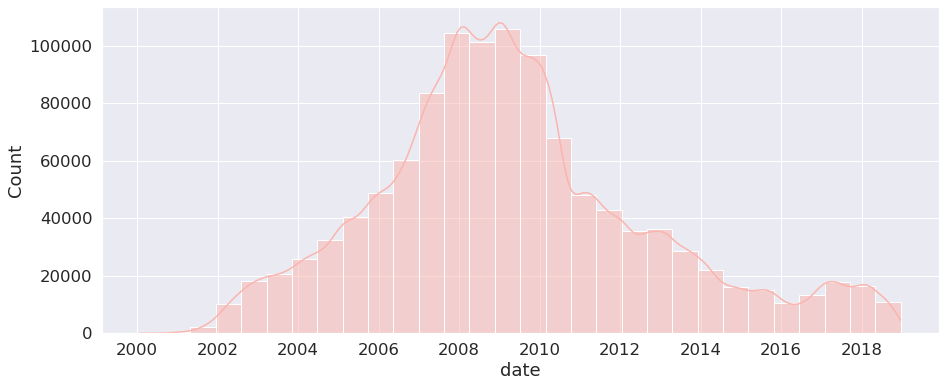

In [199]:
sns.set_palette('Pastel1')#, 1) 
fig, ax = plt.subplots(figsize=(15,6))
sns.histplot(x=idf.date, bins = 30, kde=True);

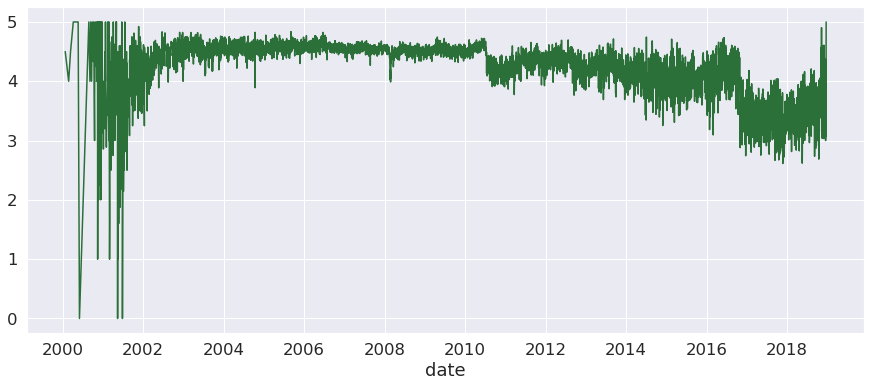

In [200]:
x = idf.groupby('date')['rating'].mean().sort_index()
sns.set_palette('cubehelix', 2) 
fig, ax = plt.subplots(figsize=(15,6))
sns.lineplot(x=x.index, y=x.values, palette='g');

In [22]:
idf.date.count()

1132367

In [23]:
idf.date.value_counts()

2008-01-27    723
2008-01-02    695
2008-06-30    692
2009-01-10    689
2008-01-06    688
             ... 
2000-11-06      1
2001-05-17      1
2000-12-19      1
2001-03-26      1
2000-10-23      1
Name: date, Length: 6396, dtype: int64

In [24]:
idf.date.describe()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  if __name__ == '__main__':


count                 1132367
unique                   6396
top       2008-01-27 00:00:00
freq                      723
first     2000-01-25 00:00:00
last      2018-12-20 00:00:00
Name: date, dtype: object

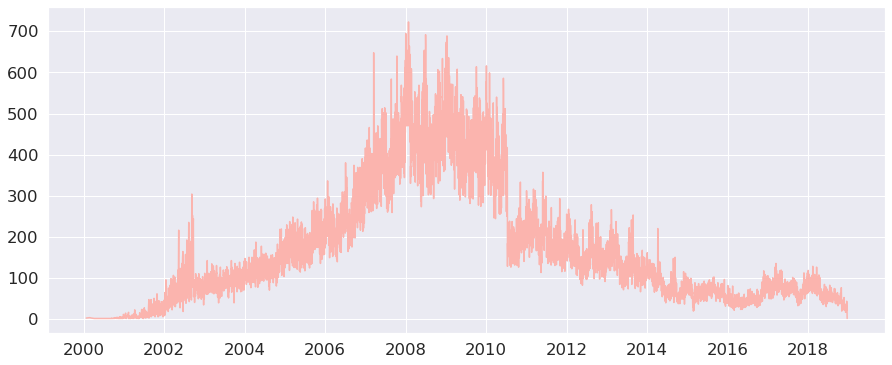

In [201]:
x = idf.date.value_counts().sort_index()
sns.set_palette('Pastel1')#, 1) 
fig, ax = plt.subplots(figsize=(15,6))
sns.lineplot(x=x.index, y=x.values); #hue=idf[idf.rating == 5].date);#palette=cmap <- for hue

In [37]:
idf[idf.date < '2003'].date.value_counts().sum()-idf[idf.date < '2002'].date.value_counts().sum()

20922

In [40]:
idf[idf.date < '2004'].date.value_counts().sum()-idf[idf.date < '2003'].date.value_counts().sum()

32961

In [38]:
idf[idf.date < '2003'].date.value_counts().sum()

23934

In [39]:
idf[idf.date < '2002'].date.value_counts().sum()

3012

In [29]:
### FIGURE THIS OUT LATER MAYBE


# x = hue_df.date.value_counts().sort_index()
# sns.set_palette('Pastel1')#, 1) 
# fig, ax = plt.subplots(figsize=(15,6))
# sns.lineplot(x=hue_df.date, 
#              y=hue_df.date.value_counts(), 
#              hue=hue_df['five']);



# fig, ax = plt.subplots(figsize=(15,6))
# ax.set_title('Density of Properties at Different Prices \n Waterfront vs. Non-waterfront', size = 18)

# sns.lineplot(data=df, x=x.index, y=x[x.five ==1].values, 
#              color = 'y', label = 'Rating = 5', kde=True, stat='density', ax = ax)
# sns.lineplot(data=df, x=x.index, y=x[x.five ==0].values, 
#              color = 'b', label = 'Ratings\nrange 0-4', bins = 30, kde=True, stat='density', ax = ax)
# ax.legend(labels=['Rating = 5', 'Ratings\nrange 0-4']);

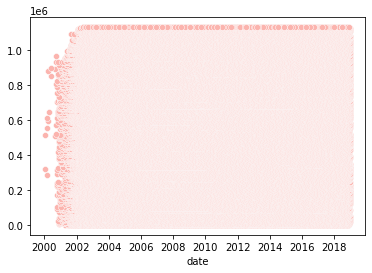

In [30]:
sns.scatterplot(x=idf.date, y=idf.index);

The date of the row's event (user interaction).

#### IDEA FOR EDA / VIS:

Can we identify if there are recipes that increase the number of a user's interactions on the site?  
  
Also, would there be a way to control for a recipe promotion? i.e.—a recipe advertised on *Food.com*'s homepage would almost certainly drive more user interaction than those that are not.

would need to look at:  
- `int_df.date`  
- mean interaction frequency 

Alternatively, we could evaluate:  
- mean number of interactions for all users after interactions with recipes with a rating of 5 vs. the rest  
- mean number of interactions for all users after interactions with recipes with a rating of 5 vs. *mean number of interactions before*  
  
  For both of the above, we can evaluate **frequency**, **length of time that the user remained active on the site**.

### `rating`

> Represents the user's rating for the recipe

Ratings of **5** are far and away the dominant class of the dataset. This disparity will be managed with weights.  
  
Further, we must consider what to do with ratings of **0**.  
  
For a recommender system, it would be easiest to simply drop zero values. The only method of imputation that would be useful would involve a sort of *Natural Language Processing*... which is to say that we would need to see how **implicit** characteristics of different recipes can be interpreted based on the word's interpreted value in **latent space**.

In [ ]:
x = idf.rating.value_counts().sort_index()
sns.set_palette('Pastel1')#, 1) 
fig, ax = plt.subplots(figsize=(15,6))
sns.barplot(x=x.index, y=x.values); #hue=idf[idf.rating == 5].date);#palette=cmap <- for hue

In [ ]:
idf.rating.value_counts()

In [ ]:
idf.rating.describe()

In [ ]:
idf.rating.values

### `review`

> Represents the user's review comment for the recipe  
  
- Contains 169 Null Values  
  - All user interactions with null review have a **non-null *and* non-zero** rating.
- Could be used for a NLP 
- Showing a word cloud in presentation would be cool

In [ ]:
idf[idf.review.isna() == True].rating.value_counts()

In [ ]:
idf[(idf.review.isna() == True) & (idf.rating == 0)]

In [ ]:
169/len(idf)

**Dominant Words in Recipes with a review of 5:**

In [ ]:
text = idf[idf.rating == 5].review.values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'salmon',
    colormap = 'Pastel1',
    collocations = 'False', # False excludes bigrams
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

**Dominant Words for all Recipes:**

In [ ]:
text = idf.review.values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (16, 9),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

**Dominant Words in Recipes with a review of 1:**

In [ ]:
cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
text = idf[idf.rating == 1].review.values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'darkgreen',
    colormap = cmap,
    collocations = 'False', # False excludes bigrams
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## RAW Recipes Data — `df`

- The RAW Recipes dataset has **231,637** total rows, with each row representing a unique recipe submission on *Food.com*  
  \* (though there appear to be **1,451** rows that share recipe `name`s in common with other rows).  
- The difference in size between RAW recipes dataset and the PP recipes dataset (size 178,265) is **53,372**.

In [ ]:
x = df.contributor_id.value_counts()
x[x>5]

In [ ]:
df.head()

In [ ]:
df.columns

In [ ]:
df.describe()

You can find the ingredient names in the RAW_recipes.csv file. I can't find the ingredient name-ID relationship, so you'll need to preprocess RAW_recipes.csv, generate PP_recipes.csv and the list of ingredient names

- The split 'interactions' datasets combined are only a portion of the full RAW interactions dataset. 
  - The difference between the RAW set and the other three combined is **413,988**.

### `name`

- 1 NaN value (**dropped**)
- **230,186** unique value (of 231,637 total)

In [ ]:
len(df.name.unique()) # 230,186

### `id`

### `minutes`

Recipe preparation/cook time.  
Values for recipe `minutes` contain outliers and/or dirtiness.  
- There are **9,970** recipes with values for `minutes` over 300 minutes.
- after review, at least [some](https://www.food.com/recipe/better-than-sex-strawberries-42198#activity-feed) of these are in fact accurate to the recipe.

FFS I'll never get this to plot. Try later with AWS.

In [ ]:
len(df[df.minutes>300])

In [ ]:
# possibly the figure represents number of seconds?
18391/60 # high values to minutes: 306.5
18391/60/60 # high values to hours: 5.1

In [ ]:
df[df.minutes > 300][0:1] # I'll have what she's having

In [ ]:
df[df.minutes > 300]

In [ ]:
# sns.histplot(df.minutes, 
#              kde = True)

In [ ]:
1051200/1440

In [ ]:
df[df.minutes == 1051200] # 7.3 days. In order to understand what is an appropriate length of time to dedocate to the process of husband preservation, I will require domain expertise in taxidermy

In [ ]:
df[df.minutes == 2147483647] # This will need to be cleaned

In [ ]:
sorted(df.minutes.unique(), reverse=True)

In [ ]:
df.minutes.value_counts()

### `contributor_id`

### `submitted`

In [ ]:
df.head()

In [ ]:
df.submitted

In [ ]:
df.columns

In [ ]:
df.lineplot

### `tags`

### `nutrition`

- Mapped values to columns that correspond to what they measure, for both improving interpretability, ease of manipulation.

  The nutrition information corresponds to:
>     [
         calories (#),  
         total fat (PDV),  
         sugar (PDV),  
         sodium (PDV),  
         protein (PDV),  
         saturated fat (PDV),  
         carbohydrates (PDV)
] 
  
Where:  
- **#** — number of calories (kcal)
- **(PDV)** — Percent Daily Value  
This information has been updated in the column descriptions as well.  
  


In [ ]:
df.head(1)

In [ ]:
df.nutrition[1] # notice how pandas series objects are treated as strings despite having the structure of a list/array

In [ ]:
# we can iterate through the object as we would through a list using the tricky method below
float(df.nutrition[1][1:-1].split(sep=', ')[0])
float(df.nutrition[1][1:-1].split(sep=', ')[-2])

### `n_steps`

### `steps`

### `description`

### `ingredients`

### `n_ingredients`

<br><br>

## Additional/Pre-processed Data

### Other Interactions Data — `int_train_df` / `int_val_df` / `int_test_df`

In [ ]:
# only reading length. Resist any temptation to read in before model evaluation.
length_int_test_df = len(pd.read_csv('data/interactions_test.csv'))                                                        
test_df_info = f'Interactions Test Set Total Rows: {length_int_test_df}'
ingredient_sets_len = (f'Interactions Train Set Total Rows: {len(int_train_df)}', \
f' Interactions Val. Set Total Rows:   {len(int_val_df)}', \
f' Interactions Test Set Total Rows:  {length_int_test_df}')
ingredient_sets_comb_len = f'   Combined Train/ Val/ Test Sets:  {length_int_test_df+len(int_train_df)+len(int_val_df)}'
raw_set_len = f'  Raw Interactions Set Total Rows: {len(int_df)}'

In [ ]:
ingredient_sets_len, \
' ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾', \
ingredient_sets_comb_len, \
'‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾', \
raw_set_len

In [ ]:
len(int_df)-(int_test_df+len(int_train_df)+len(int_val_df)) # Difference between raw int. set and combined int. train/val/test sets

In [ ]:
int_test_df.columns

In [ ]:
int_train_df.head()

In [ ]:
x = int_train_df.recipe_id.value_counts()
x[x > 30]

In [ ]:
(len(int_test_df)+len(int_train_df)+len(int_val_df), len(int_df))

### Preprocessed User Data

In [ ]:
usr_df.columns

RE: The meaning behind **Techniques**  
> "I stumbled the same problem. In the paper related to this datasets they mention that they manually constructed a techniques list of 58 different techniques. It doesn't appear on the paper but if you'll look at the project's code on [github](https://github.com/majumderb/recipe-personalization/tree/master/recipe_gen) in language.py file (lines 150-208) you'll see an ordered list of all the techniques they probably used.
So I guess this is the proper mapping for the one-hot vector in the dataset "techniques" field."

In [ ]:
usr_df.tail()

In [ ]:
max(sorted(usr_df.groupby('u')['n_items']))

#### Preprocessed Recipes Data

In [ ]:
pp_df.tail()

#### Ingredient ID Mapping Dataset

In [ ]:
ingID_df = pd.DataFrame(ingID)

In [ ]:
ingID_df.iloc[37:50]

## About the Dataset

This dataset consists of **180K+ recipes** and **700K+ recipe reviews** covering 18 years of user interactions and uploads on *Food.com* (formerly *GeniusKitchen*) used in the paper listed below under section:  
> - **Resources/**  
>  - ***Food.com Recipes and Interactions* — Full Description/**  
>    - **Acknowledgements**

This dataset contains three sets of data from *Food.com*:

**Interaction splits**

- `interactions_test.csv`
- `interactions_validation.csv`
- `interactions_train.csv`
  
**Preprocessed data for result reproduction**  
In this format, the recipe text metadata is tokenized via the GPT subword tokenizer with start-of-step, etc. tokens.

- `PP_recipes.csv`
- `PP_users.csv`
  
  To convert these files into the `pickle` format required to run our code off-the-shelf, you may use `pandas.read_csv` and `pandas.to_pickle` to convert the CSV's into the proper `pickle` format.

  The nutrition information corresponds to:
  > `[calories (#),`  
  `total fat (PDV),`  
  `sugar (PDV),`  
  `sodium (PDV),`  
  `protein (PDV),`  
  `saturated fat (PDV),`  
  `carbohydrates (PDV)]` 
  
- **(PDV)** — Percent Daily Value  
This information has been updated in the column descriptions as well.

`u` and `i` are contiguous integer IDs for users and recipes, respectively. These are contiguous so you can use them for tensor/array indexing.

# *Recipe Ingredients Dataset*

> Use recipe ingredients to classify cuisine

This is another interesting dataset for classifying a particular recipe's culinary style of cuisine based on its listed ingredients. There are no quantities listed in the ingredients lists, but it would be an interesting project to model, and might have additional use for a later-stage stretch goal, if I continue with a project based on recipes.

In [ ]:
ing = open('data/train.json')
data = json.load(ing)
ing_df = pd.DataFrame(data)
ing_df

In [ ]:
# data

# Resources

I have used the below code to download the large csv files to this notebook instance's data folder.  
Running again should not be necessary but do if there is an error setting the data to a DataFrame variable below.

In [6]:
# try:
#     urllib.request.urlretrieve ('https://sagemaker-studio-t1ems8mtnoj.s3.us-east-2.amazonaws.com/RAW_interactions.csv', 'data/RAW_interactions.csv')
#     print('Success: downloaded RAW_interactions.csv.')
# except Exception as e:
#     print('Data load error: ',e)

# try:
#     idf = pd.read_csv('data/RAW_interactions.csv',index_col=0)
#     print('Success: Data loaded into dataframe.')
# except Exception as e:
#     print('Data load error: ',e)

# try:
#     urllib.request.urlretrieve ('https://sagemaker-studio-t1ems8mtnoj.s3.us-east-2.amazonaws.com/PP_recipes.csv', 'data/PP_recipes.csv')
#     print('Success: downloaded PP_recipes.csv.')
# except Exception as e:
#     print('Data load error: ',e)

## *Food.com Recipes and Interactions* — Full Description


### Source

> [Orginally Sourced on Kaggle](https://www.kaggle.com/shuyangli94/food-com-recipes-and-user-interactions/discussion/121778), provided by [Shuyang Li](https://www.kaggle.com/shuyangli94)

### Context

This dataset consists of 180K+ recipes and 700K+ recipe reviews covering 18 years of user interactions and uploads on *Food.com* (formerly *GeniusKitchen*) used in the paper listed below under **Acknowledgements**.

### Content

This dataset contains three sets of data from *Food.com*:

**Interaction splits**

- `interactions_test.csv`
- `interactions_validation.csv`
- `interactions_train.csv`
  
**Preprocessed data for result reproduction**  
In this format, the recipe text metadata is tokenized via the GPT subword tokenizer with start-of-step, etc. tokens.

- `PP_recipes.csv`
- `PP_users.csv`
  
  To convert these files into the `pickle` format required to run our code off-the-shelf, you may use `pandas.read_csv` and `pandas.to_pickle` to convert the CSV's into the proper `pickle` format.

### Acknowledgements

>*Generating Personalized Recipes from Historical User Preferences*  
Bodhisattwa Prasad Majumder*, Shuyang Li*, Jianmo Ni, Julian McAuley
EMNLP, 2019  
https://www.aclweb.org/anthology/D19-1613/

### Citation

> Shuyang Li, *Food.com Recipes and Interactions* (2019),  
doi:10.34740/KAGGLE/DSV/783630.

## *Recipe Ingredients* Dataset — Full Description

### Source

> [Originally Sourced from Kaggle](https://www.kaggle.com/kaggle/recipe-ingredients-dataset)

### Context

If you're in Northern California, you'll be walking past the inevitable bushels of leafy greens, spiked with dark purple kale and the bright pinks and yellows of chard. Across the world in South Korea, mounds of bright red kimchi greet you, while the smell of the sea draws your attention to squids squirming nearby. India’s market is perhaps the most colorful, awash in the rich hues and aromas of dozens of spices: turmeric, star anise, poppy seeds, and garam masala as far as the eye can see. Some of our strongest geographic and cultural associations are tied to a region's local foods.  
  
This dataset was featured in our completed playground competition entitled What's Cooking? The objective of the competition was to predict the category of a dish's cuisine given a list of its ingredients.

### Content

The data are stored in JSON format.  
- **train.json** — the training set containing recipes id, type of cuisine, and list of ingredients  
- **test.json** — the test set containing recipes id, and list of ingredients  
  
An example of a recipe node in `train.json` can be found [here](https://www.kaggle.com/c/whats-cooking/data) or in the file preview section below.

### Acknowledgements

This unique dataset was provided by [Yummly](http://www.yummly.com/) and featured in a Kaggle playground competition for fun and practice. Visit the competition page if you are interested in checking out past discussions, competition leaderboard, or more details regarding the competition. If you are curious to see how your results rank compared to others', you can still make a submission at the [competition submission page](https://www.kaggle.com/c/whats-cooking/submissions/attach)!

## Functions

**These will be moved to a separate file located at the following path:**  
- `code/functions.py`

In [ ]:
# def head(data='interactions', disp_head=3):
#     """
#     ### Dev. note: THIS WOULD BE BETTER WITHIN A DEFINED CLASS SO THAT I COULD SWITCH IT UP MORE EASILY ###
    
#     Takes in a dataframe and sets display.max_colwidth before returning the dataframe.head().
    
#         Default for int_df: display.max_colwidth = 200
        
#         Default for all other dataframes: display.max_colwidth = 50
    
#     Parameters = (data: DataFrame, disp_head: int):
    
#         data: 'interactions' or 'recipes'. 
        
#             Default: data = interactions

#         disp_head: Non-negative integer number of first rows to display. 

#             Default for interactions: 11
#             Default for all other dataframes: 3
    
#     """
#     num_rows = 3
#     if disp_head > 0:
#         num_rows = disp_head
#     if data == 'interactions':
#         pd.set_option('display.max_colwidth', 200)
#         num_rows = 11
#         return int_df.head(num_rows)
#     elif data == 'recipes':
#         pd.set_option('display.max_colwidth', 50)
#         return df.head(num_rows)